<a href="https://colab.research.google.com/github/omkar-mohanty/3D-Classifier/blob/main/utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks

* Threaded Voxelizer loader

* Insert Latent feature data instead of Voxel data in All ML models and charts   

* Data Set Visualization

* Make folder of 20 custom 3d models

* Map classification numbers to names

# Notebooks


1. Original training workflow
2. Augmented data training workflow
3. Utility functions and dataset visualizations
4. Observations and charts of trained model



# Prerequisites

In [49]:
# Copied straight from the requirements.txt becuse idk how to do in colab :(
!pip install git+https://github.com/omkar-mohanty/PyVoxelizer
!pip install numpy>=1.12.1
!pip install git+https://github.com/p-hofmann/MeshReader.git#egg=meshlib
!pip install meshlib>=0.0.2
!pip install matplotlib
!pip install h5py

  Cloning https://github.com/omkar-mohanty/PyVoxelizer to /tmp/pip-req-build-dewzu4ns
  Running command git clone --filter=blob:none --quiet https://github.com/omkar-mohanty/PyVoxelizer /tmp/pip-req-build-dewzu4ns
  Resolved https://github.com/omkar-mohanty/PyVoxelizer to commit 59c4f47224a46588903657749ea7f818667f58c2
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/p-hofmann/MeshReader.git to /tmp/pip-install-95sdlvq5/meshlib_311da3085d0a4cfaae76b8cc7634ec98
  Running command git clone --filter=blob:none --quiet https://github.com/p-hofmann/MeshReader.git /tmp/pip-install-95sdlvq5/meshlib_311da3085d0a4cfaae76b8cc7634ec98
  Resolved https://github.com/p-hofmann/MeshReader.git to commit 9296482d0ad6f0c944b065619df04ffcf5a4cf9e
  Preparing metadata (setup.py) ... done


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Utils

In [51]:
import voxlib.voxelize
"""
Voxelize function outputs (x,y,z) coordinates where the voxel exists, but we need the full dim * dim * dim 3D matrix.
This function initializes a matrix of size dim * dim * dim then fills it up with all zeros first. Then loops over the filled voxel
coordinates and puts 1.0 into them.
"""
def normvox(filename, dim):
    coordinates = voxlib.voxelize.voxelize(filename, dim)

    matrix_size = (dim, dim , dim)
    matrix = [[[0.0 for _ in range(matrix_size[2])] for _ in range(matrix_size[1])] for _ in range(matrix_size[0])]

    for coord in coordinates:

      x, y, z = coord
      "Works for even dimensions only"
      x += int(dim/2) - 1
      y += int(dim/2) - 1
      z += int(dim/2) - 1
      matrix[x][y][z] = 1.0

    return matrix

In [52]:
"""
The ML model expects the data to be in a 1D numpy array, but for our purposes we initially interpret the data as a 3D matrix.
This code converts the 3D voxel matrix[dim][dim][dim] into flattened array[dim * dim * dim]
"""
def flatten_3d_mat(matrix, dim):
  flattened_data = [0 for _ in range(dim * dim * dim)]
  idx = 0
  for x in range(dim):
    for y in range(dim):
      for z in range(dim):
        flattened_data[idx] = matrix[x][y][z]
        idx += 1
  return flattened_data

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_voxel_grid(matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    matrix = matrix.reshape(matrix.shape[1:4])
    filled = matrix == 1.0  # This assumes that the matrix uses 1.0 for filled voxels
    ax.voxels(filled, facecolors='blue', edgecolor='k')
    plt.show()

def plot_voxel_grid_rotate(matrix, axis='y', k=1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    matrix = matrix.reshape(matrix.shape[1:4])

    # Rotate the matrix
    if axis == 'z':
        matrix = np.rot90(matrix, k=k, axes=(0, 1))  # Rotate k times around z-axis (y-x plane)
    elif axis == 'x':
        matrix = np.rot90(matrix, k=k, axes=(1, 2))  # Rotate k times around x-axis (z-y plane)
    elif axis == 'y':
        matrix = np.rot90(matrix, k=k, axes=(0, 2))  # Rotate k times around y-axis (z-x plane)

    filled = matrix == 1.0  # This assumes that the matrix uses 1.0 for filled voxels
    ax.voxels(filled, facecolors='blue', edgecolor='k')
    plt.show()


In [54]:
def print_mat_ct_scan(matrix, dim):
  for i in range(dim):
      for j in range(dim):
          for k in range(dim):
              print(matrix[i][j][k], end=" ")
          print()
      print()

In [55]:
"""
Converts a h5py dataset np array into a 3d matrix generator of given dimensions
"""
import h5py
def open_dataset_all(file_path, dim, data_type = 'train'):
  data = h5py.File(file_path)
  train_data = np.transpose(data[data_type])

  data_map = {idx[0]: [] for idx in train_data }

  for idx in range(0, len(train_data)):
    data_point = train_data[idx]
    single_vox = np.array(data_point[1:]).reshape((1, 30, 30, 30, 1)).astype('float32')
    data_map[data_point[0]].append(single_vox)
  return data_map


def open_dataset(file_path, dim, data_type = 'train'):
  data = h5py.File(file_path)
  train = data[data_type]
  transpose = np.transpose(train)

  matrix_size = (dim, dim, dim)

  # Initialize the 3D matrix with zeros
  matrix = [[[0.0 for _ in range(matrix_size[2])] for _ in range(matrix_size[1])] for _ in range(matrix_size[0])]

  for elem in range(0, len(transpose)):
    indx = 0;
    entry = transpose[elem][1:];
    for i in range(matrix_size[0]):
        for j in range(matrix_size[1]):
            for k in range(matrix_size[2]):
              matrix[i][j][k] = entry[indx]
              indx += 1
    yield matrix

In [56]:
def dataset_dict(dataset_labels : list[str], offset = 0) -> dict:
    return {key: float(index  + offset) for index, key in enumerate(dataset_labels)}
print(dataset_dict(["Fyre", "Leo"], 1))

{'Fyre': 1.0, 'Leo': 2.0}


# Dataset Class

In [57]:
class DataSet:
  def __init__(self, labels: list[str], file: str, dim = 30, data_type = 'train'):
    self.data_map = open_dataset_all(file, dim, data_type)
    self.label_map = dataset_dict(labels, 1)
    self.dim = dim
    self.data_type = data_type

  def get_models_by_key(self, label: str):
    idx = self.label_map[label]
    return self.data_map[idx]

  def get_models_by_id(self, id:float):
    return self.data_map[id]

In [58]:
labels = ['bathtub', 'bed', 'chair', 'desk', 'dresser',
               'monitor', 'night_stand', 'sofa', 'table', 'toilet']

In [59]:
dataset = DataSet(labels, file = "/content/drive/MyDrive/ModelNet10_res30_raw.mat")

In [60]:
chairs = dataset.get_models_by_key('chair')

In [61]:
bathtubs = dataset.get_models_by_key('bathtub')
bathtubs_by_id = dataset.get_models_by_id(1.0)

assert bathtubs_by_id == bathtubs

In [62]:
beds = dataset.get_models_by_key('bed')

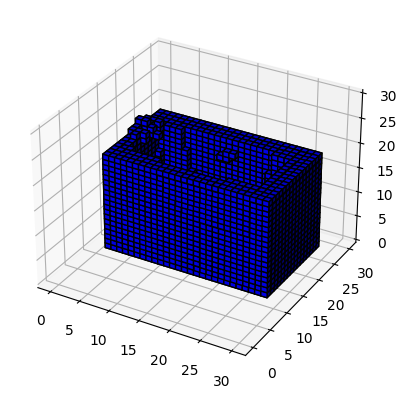

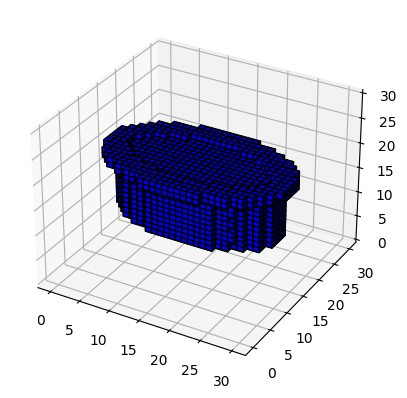

In [63]:
for idx in range(2):
  plot_voxel_grid_rotate(bathtubs[idx])

# One From Each

Label : bathtub


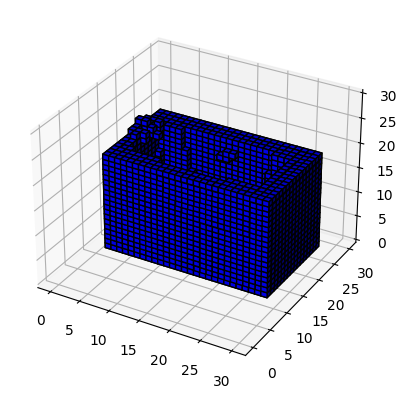

Label : bed


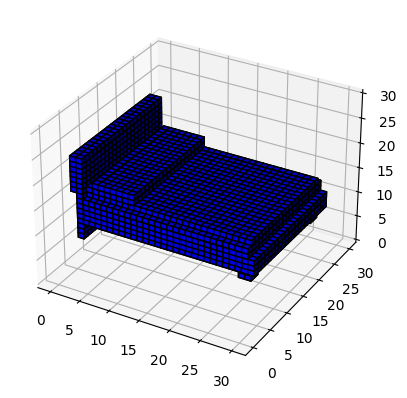

Label : chair


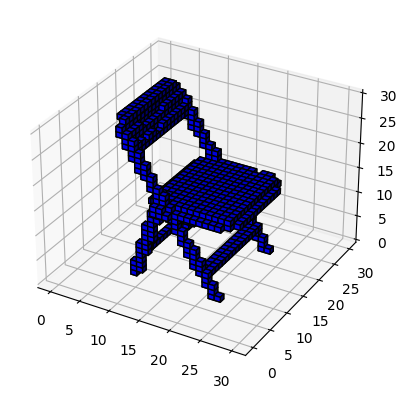

Label : desk


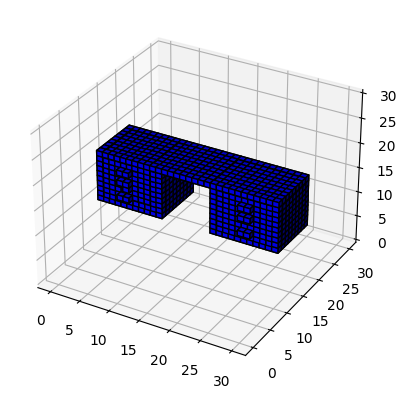

Label : dresser


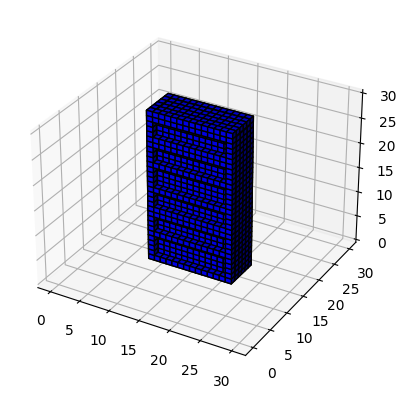

Label : monitor


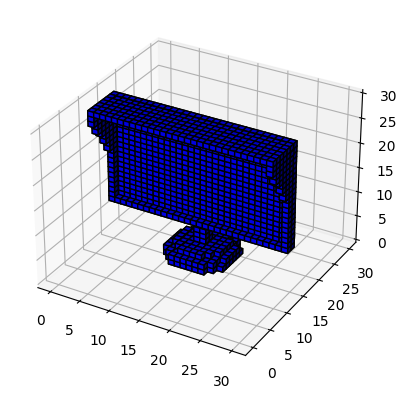

Label : night_stand


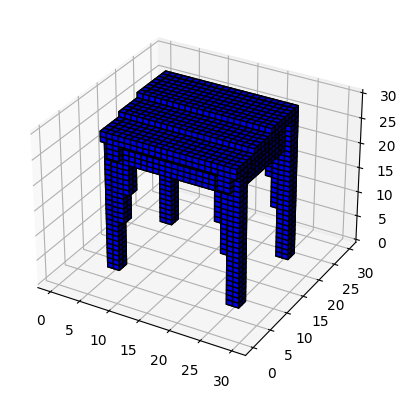

Label : sofa


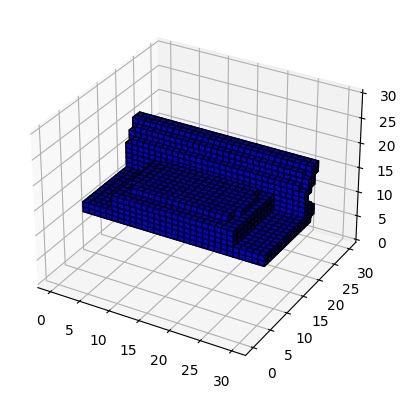

Label : table


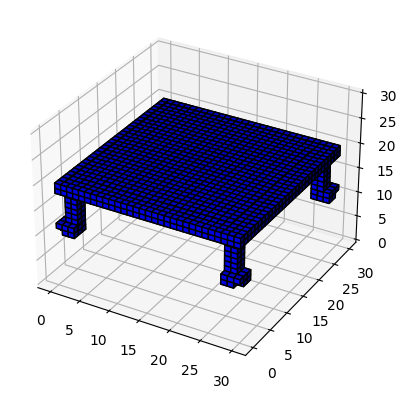

Label : toilet


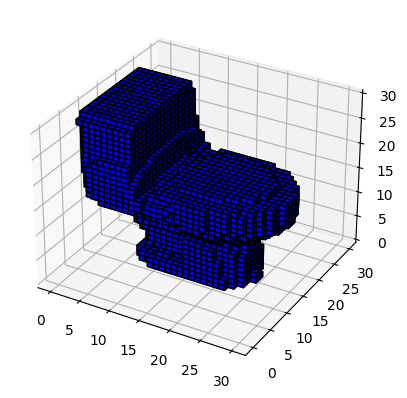

In [64]:
for label in labels:
  data = dataset.get_models_by_key(label)
  print("Label : " + label)
  plot_voxel_grid_rotate(data[0])

# Data Preprocessing

In [65]:
class VoxelModel:
  """
    filename: Must end with .stl
    dim: must be even
  """
  def __init__(self, filename, dim):
    self.mat = normvox(filename, dim)
    self.dim = dim

  def show_ct(self):
    print_mat_ct_scan(self.mat)

  def show_3d(self):
    new_voxel = np.expand_dims(np.array(self.mat), axis=(0, -1)).astype('float32')
    plot_voxel_grid_rotate(new_voxel)

  def flattened(self):
    return flatten_3d_mat(self.mat, self.dim)

In [66]:
import os
import threading


def thread_vox(model_dir: str = "/content/drive/MyDrive/Models"):
  lock = threading.Lock()

  threads = []
  models = []

  def load_model(filename, dim):
    try:
      model = VoxelModel(filename, dim)
      with lock:
        models.append(model)
    except Exception as e:
      print("Load Error for " + filename + e)

  for file in os.listdir(model_dir):
    if file.endswith(".stl"):
      thread = threading.Thread(target = load_model, args = (model_dir +"/" + file, 30))
      thread.start()
      threads.append(thread)


  for thread in threads:
      thread.join()
  return models

In [67]:
voxels = thread_vox("/content/drive/MyDrive/Models/Test")
print(len(voxels))

Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |===================-| 98.8% 

3


Voxelize:  |====================| 100.0% 


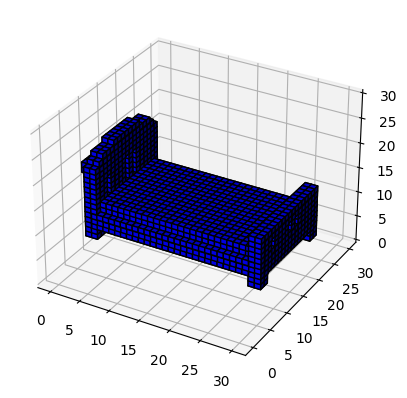

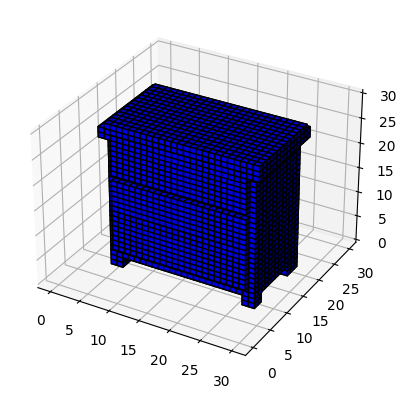

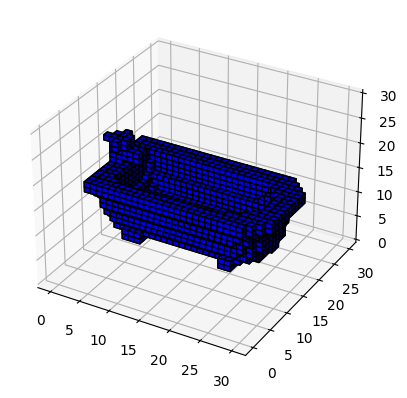

In [68]:
for voxel in voxels:
  voxel.show_3d()

In [69]:
voxels = thread_vox()

Voxelize:  |--------------------| 1.7% Exception in thread Thread-45 (load_model):
Traceback (most recent call last):
  File "<ipython-input-66-ce6d5787e665>", line 13, in load_model
Voxelize:  |--------------------| 1.7%   File "<ipython-input-65-1be20d49bdba>", line 7, in __init__
  File "<ipython-input-51-6a8d9651ba43>", line 13, in normvox
  File "/usr/local/lib/python3.10/dist-packages/voxlib/voxelize.py", line 181, in voxelize
    scale, shift, triangle_count = get_scale_and_shift(list_of_triangles, resolution)
  File "/usr/local/lib/python3.10/dist-packages/voxlib/mesh.py", line 14, in get_scale_and_shift
    mins = list(mesh[0][0])
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython

In [70]:
print(len(voxels))

7


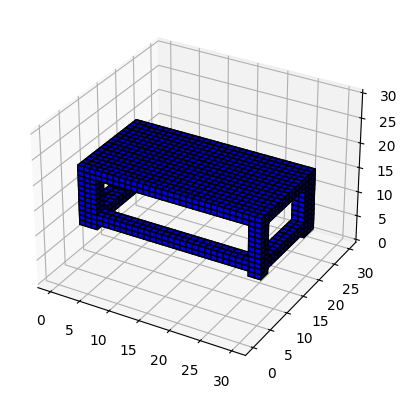

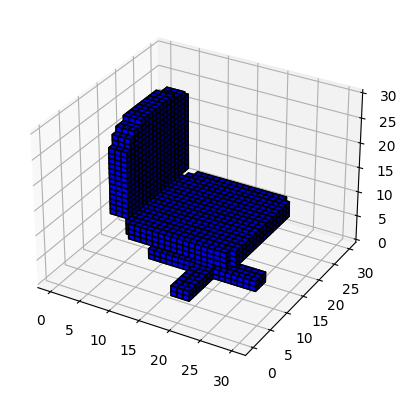

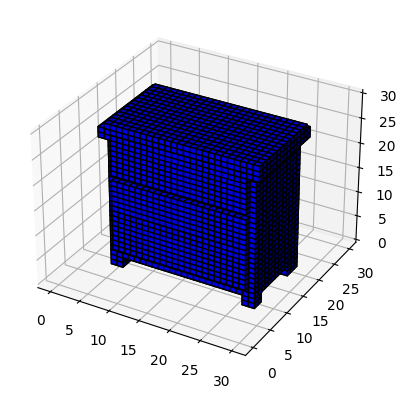

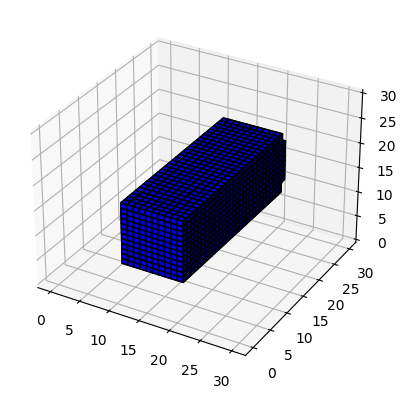

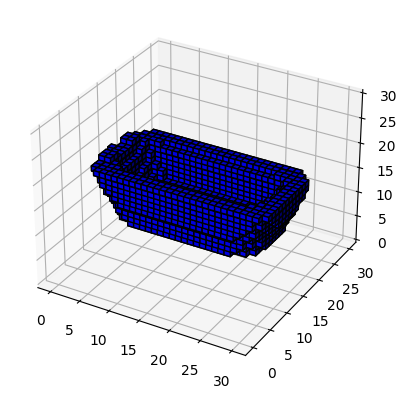

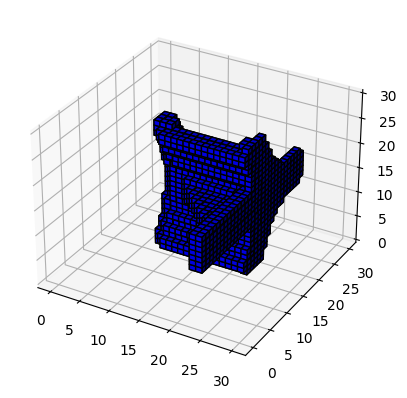

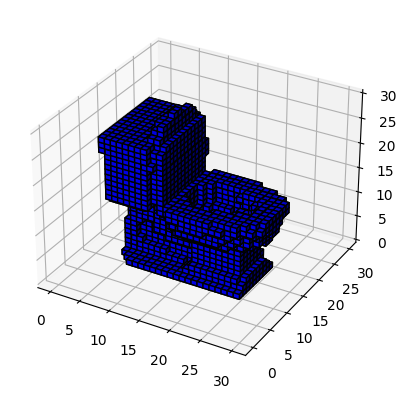

In [71]:
for voxel in voxels:
  voxel.show_3d()

# Dataset Visualization

In [72]:
data = open_dataset_all("/content/drive/MyDrive/ModelNet10_res30_raw.mat", 30, data_type = 'train')


In [73]:
# Load dataset (modelnet10)
file_path = '/content/drive/MyDrive/ModelNet10_res30_raw.mat'
data = h5py.File(file_path, 'r')

train_data = np.transpose(data['train'])
test_data = np.transpose(data['test'])

# single_data_point = train_data[369]

# # Step 1: Preprocess the single data point
# single_voxel = np.array(single_data_point[1:]).reshape((1, 30, 30, 30, 1)).astype('float32')
# plot_voxel_grid3(single_voxel, axis = 'y')

# for idx in range(0, len(train_data), 400):
#   data_point = train_data[idx]
#   print(data_point[0])
#   single_vox = np.array(data_point[1:]).reshape((1, 30, 30, 30, 1)).astype('float32')
#   plot_voxel_grid(single_vox)

In [74]:
map = {idx[0]: [] for idx in train_data}
print(map)
map = {idx[0]: [] for idx in test_data}
print(map)

{1.0: [], 2.0: [], 3.0: [], 4.0: [], 5.0: [], 6.0: [], 7.0: [], 8.0: [], 9.0: [], 10.0: []}
{1.0: [], 2.0: [], 3.0: [], 4.0: [], 5.0: [], 6.0: [], 7.0: [], 8.0: [], 9.0: [], 10.0: []}


In [75]:
# model = next(data)

# print_mat_ct_scan(model, 30)